# FFT-FFN Model 

Build a FeedForward Network to learn a representation of the Fourier transformed Time Series Data (presumably built to learn/recreate signals without the time series component in LSTMs)


<BR>


- Get as close to possible as the TS-LSTM Version (increase number of neurons to match LSTM # parameters)


In [1]:
import os 
import random
import numpy as np 
import time
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model

# from StockData import * 
from StockDataToGinis import * 

def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    # tf.keras.utils.set_random_seed(seed) #alt version of tf
    tf.random.set_seed(seed)
    np.random.seed(seed)


In [130]:
# Read in Saved TSVs of Array Data & Reshape

stock_data = "../Data Quality (Stocks)/Stocks_Cleaned.csv"
WINDOW_LEN = 20 #number of days to pull data for (in original random sequence generator), test set size, reshape in MinMaxScaler

X_train = np.loadtxt("autoencoder_data/train.tsv")
X_test = np.loadtxt("autoencoder_data/test.tsv")

# Reshape to fit LSTM Data Schema
X_train = X_train.reshape(9980, 1, 20)
X_test = X_test.reshape(20, 1, 20)
X_test_original = np.copy(X_test) #for comparing reconstruction against (non-transformed)

# Get Train & Val Splits
X_val = X_train[-100:] #val needs go first! (train gets reassigned)
X_train = X_train[:-100]


In [119]:
# Testing Fourier -- How to reconstruct original sequence after NN Forward Pass?
print(X_test_original[0])

X_test = fourier_transform(X_test_original, inverse=False)
print(X_test[0])


# print after inverse transform
# X_test = fourier_transform(X_test, inverse=True)
# print(X_test[0])
stacked = np.hstack([X_test[0].real, X_test[0].imag])

print(stacked.shape)


fourier_transform(X_test[0].real, inverse=True)

# Non-essential code

[[0.64217345 0.62967078 0.64261125 0.64621485 0.66139186 0.67580236
  0.63869916 0.64262218 0.65398687 0.66073835 0.64565685 0.63684141
  0.63684141 0.64533809 0.63781343 0.65901564 0.63872544 0.63733877
  0.63931496 0.65549587]]
[[ 1.29262930e+01+0.00000000e+00j -1.77868178e-02-5.55893602e-02j
  -4.16559529e-02+1.85701881e-02j -2.29343961e-02+1.08453690e-02j
   5.51827121e-02+8.29570639e-02j  2.90233885e-02-8.69840093e-03j
  -4.98814657e-02+2.52470436e-02j -1.67238577e-02+2.20406865e-02j
   3.82915424e-02+1.78322673e-02j  1.10046603e-02+1.32402132e-02j
  -5.18636026e-02-3.46944695e-18j  1.10046603e-02-1.32402132e-02j
   3.82915424e-02-1.78322673e-02j -1.67238577e-02-2.20406865e-02j
  -4.98814657e-02-2.52470436e-02j  2.90233885e-02+8.69840093e-03j
   5.51827121e-02-8.29570639e-02j -2.29343961e-02-1.08453690e-02j
  -4.16559529e-02-1.85701881e-02j -1.77868178e-02+5.55893602e-02j]]
(1, 40)


array([[0.64217345, 0.64258332, 0.6409631 , 0.64177681, 0.65005865,
        0.667409  , 0.63825629, 0.64398014, 0.64541414, 0.64878988,
        0.64565685, 0.64878988, 0.64541414, 0.64398014, 0.63825629,
        0.667409  , 0.65005865, 0.64177681, 0.6409631 , 0.64258332]])

In [131]:
# Normalization -- MinMax Transformation (saving object for inverse transform)
from sklearn.preprocessing import MinMaxScaler


# Instantiate MinMax Scalers & Fit 
X_mms = MinMaxScaler()
X_mms.fit(X_train[:, 0, :])

X_train = X_mms.transform(X_train[:, 0, :])
X_train = X_train.reshape((len(X_train), 1, WINDOW_LEN))

X_val = X_mms.transform(X_val[:, 0, :])
X_val = X_val.reshape((len(X_val), 1, WINDOW_LEN))

X_test = X_mms.transform(X_test[:, 0, :])
X_test = X_test.reshape((len(X_test), 1, WINDOW_LEN)) 
X_test_original = X_mms.transform(X_test_original[:, 0, :]) #also MinMax Scale original Test set, do not FFT
X_test_original = X_test_original.reshape((len(X_test_original), 1, WINDOW_LEN))


# Need Fourier Transform for Linear Autoencoder
X_train = fourier_transform(X_train, inverse=False)
X_val = fourier_transform(X_val, inverse=False)
X_test = fourier_transform(X_test, inverse=False)

# Manual Subset first half of output
X_train = [i[0][1:11] for i in X_train]
X_val = [i[0][1:11] for i in X_val]
X_test = [i[0][1:11] for i in X_test]

# Convert ndarrays to tf tensors -- `float32` used in TS-LSTM, need complex dtype for Fourier Output?
X_train = tf.convert_to_tensor(X_train, dtype=tf.complex64)
X_val = tf.convert_to_tensor(X_val, dtype=tf.complex64)
X_test  = tf.convert_to_tensor(X_test, dtype=tf.complex64)


# Convert Train & Val Splits into TensorFlow Datasets (easy batch iteration)
batch_size = 10 #good size for this dataset (sufficient updates for time)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train))
train_dataset = train_dataset.shuffle(buffer_size=10000, seed=42).batch(batch_size) #perfect shuffling, will sample from all data points

val_dataset = tf.data.Dataset.from_tensor_slices((X_val))
val_dataset = val_dataset.batch(batch_size)

In [132]:
# Autoencoder Architecture -- Linear Autoencoder
class FFT_FFN(Model):
  @tf.autograph.experimental.do_not_convert
  def __init__(self, latent_large, latent_small):
    super(FFT_FFN, self).__init__()
    self.latent_large = latent_large
    self.latent_small = latent_small
      
    self.encoder = tf.keras.Sequential([
      layers.Dense(20, name="input"), #input layer
      layers.Dense(latent_large, activation='tanh', name="dense-1"), #can convert back into dense layers -- need experiment 
      layers.Dense(latent_small, activation='tanh', name="dense-2")
                                        ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(latent_small, activation='tanh', name="dense-3"),
      layers.Dense(latent_large, activation='tanh', name="dense-4"),
      layers.Dense(20, activation='tanh') #output effectively (20 value, reconstructed sequence), activation typically used here is sigmoid but relu fits better in this use case
                                        ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded




# Root Mean Squared Loss -- Using Keras Provided instead 
def rmse_loss(target_y, predicted_y):
  return tf.matrix_square_root(tf.reduce_mean(tf.square(target_y - predicted_y))) 
  # return tf.reduce_mean(tf.square(target_y - predicted_y)) #original MSE loss function


# Macro Training Func w Batches & Epochs (wraps forward pass/backprop in step)
def train(epochs=int, model=None, save_best=False):
  history = {"train":[], "val":[], "test":[]} #hold eval metrics for plotting
  best_test_acc = 0 #if saving best test set accuracy model weights

  for epoch in range(epochs):
    start_time = time.time()

    # Iter through Batches
    for i, x_batch_training in enumerate(train_dataset):

      loss = train_step(x_batch_training, model)

    train_acc = train_acc_metric.result() #return training results from batches


    # Run Validation Loop per Epoch
    for x_batch_val in val_dataset:
        val_reconstruction = val_step(x_batch_val, model)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()

    # Eval on Test Reconstruction per Epoch
    _, test_acc = reconstruction_accuracy(X_test_original, model, show=False) #COMPARING TO ORIGINAL SEQUENCE

    # Print Accuracies
    print(f"Epoch {epoch} - Time: {(time.time() - start_time):.2f}s")
    print(f"Train: {float(train_acc):.4f} - Val: {float(val_acc):.4f} - Test: {float(test_acc):.4f}\n")

    # Append Results to Dict & Reset Metric States
    history["train"].append(float(train_acc))
    history["val"].append(float(val_acc))
    history["test"].append(float(test_acc))

    train_acc_metric.reset_states()
    val_acc_metric.reset_states()

    # Save Best Models Weights from Training
    if save_best:
      if best_test_acc <= test_acc:
        model.save('models/TS-LSTM/')
        print("Saved new Best Model")


  history["epochs"] = [i for i in range(0, epochs)] 
  return history


##-- Step Funcs, Static Compiled for 10x Speed Up --##

# Forward & Backward Pass on Model 
@tf.function #decorator does static compiling, 10x faster
@tf.autograph.experimental.do_not_convert
def train_step(x, model):
  with tf.GradientTape() as tape:

    # Forward Pass
    x_reconstruction = model(x)

    # Compute Loss
    loss = loss_fn(x_reconstruction, x)

  # Get Gradients wrt Loss
  grads = tape.gradient(loss, model.trainable_weights)

  # Backprop w Gradient Descent
  optimizer.apply_gradients(zip(grads, model.trainable_weights))

  train_acc_metric.update_state(x, x_reconstruction) #update training metric per batch
  return loss

# Validation Step -- compiled for 10x speedup
@tf.function
@tf.autograph.experimental.do_not_convert
def val_step(x, model):
  val_reconstruction = model(x)
  # Update val metrics
  val_acc_metric.update_state(x, val_reconstruction)
  return val_reconstruction


##-- TEST SET EVALUATION FUNCTIONS --##

# Test Reconstruction Accuracy Func -- Gauge Autoencoder performance on a Test Set
def reconstruction_accuracy(test_set, model, show=True):
    # Get Preds for Test -- inverse transform
    decoded = model.call(test_set).numpy()
    decoded = fourier_transform(decoded, inverse=True)

    # Get Error Statistics
    mse = (np.sum(test_set-decoded)**2)/len(decoded)
    mse = float(mse)
    rmse = np.sqrt(mse)
    
    avg_rmse = rmse/len(decoded)

    if show:
        print(f"Total RMSE for Entire Set: {100 * rmse:.2f}%\n  Average RMSE per Example: {100 * avg_rmse:.2f}%")
    else:
        return rmse, avg_rmse

# Plot Sequences from Test Set (Visual Evaluation of Reconstructions)
def plot_reconstruction(model, test_set, original_set, indicies):
    # Get Preds from Model + Inverse FFT
    decoded_data = model.call(test_set).numpy()
    # decoded_data = fourier_transform(decoded_data, inverse=True)
    
    # Generate Plots
    print("Recreations of Original Signals")
    for i in indicies: #change this for different curves
        x_pred_plot = decoded_data[i]
        # x_test_plot = X_test[i].numpy().reshape(-1) #case when original set was a Tensor (TS-LSTM)
        x_test_plot = original_set[i].reshape(-1)

        # Inverse Transform -- need reshape twice, MinMaxScaler expects mulit-dim array & Plotter needs 1d array
        # x_pred_plot = X_mms.inverse_transform(x_pred_plot.reshape(1, 20)).reshape(-1)
        x_pred_plot = x_pred_plot.reshape(1, 20).reshape(-1)

        # x_test_plot = X_mms.inverse_transform(x_test_plot.reshape(1, 20)).reshape(-1) 
        x_test_plot = x_test_plot.reshape(1, 20).reshape(-1)

        # Get Error Statistics
        mse = (np.sum(x_test_plot - x_pred_plot)**2)/len(x_test_plot)
        rmse = float(np.sqrt(mse))

        # Plot Difference Curves
        plt.plot(x_test_plot, "#56B9FF")
        plt.plot(x_pred_plot, '#ABE9B3')
        plt.fill_between(np.arange(20), x_pred_plot, x_test_plot, color='#F28FAD', alpha=0.5)
        plt.legend(labels=["Original", "Reconstructed", "Error"])

        plt.title(f"Index: {i} - RMSE: {100 * rmse:.2f}%")
        plt.xlabel("Time (Days)")
        plt.ylabel("Gini")
        plt.show()

    return




# Instantiate Autoencoder
set_seeds(seed=42)

autoencoder = FFT_FFN(latent_large=50, latent_small=20)
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
loss_fn = keras.losses.MeanSquaredError()
autoencoder.compile(optimizer=optimizer, loss=loss_fn)

# Train & Val Metrics
train_acc_metric = keras.metrics.RootMeanSquaredError()
val_acc_metric = keras.metrics.RootMeanSquaredError()

# Build & Summarize Model
autoencoder.build(input_shape=X_train.shape)
autoencoder.summary()

Model: "fft_ffn_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_42 (Sequential)  (9880, 20)                2290      
                                                                 
 sequential_43 (Sequential)  (9880, 20)                2490      
                                                                 
Total params: 4,780
Trainable params: 4,780
Non-trainable params: 0
_________________________________________________________________


/Users/ckg-files/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [133]:
# Run Training

n_epochs = 50
set_seeds() #reproducibility


history = train(n_epochs, autoencoder)

ValueError: Dimensions must be equal, but are 10 and 20 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_COMPLEX64](args_0, mean_squared_error/Cast)' with input shapes: [10,10], [10,20].

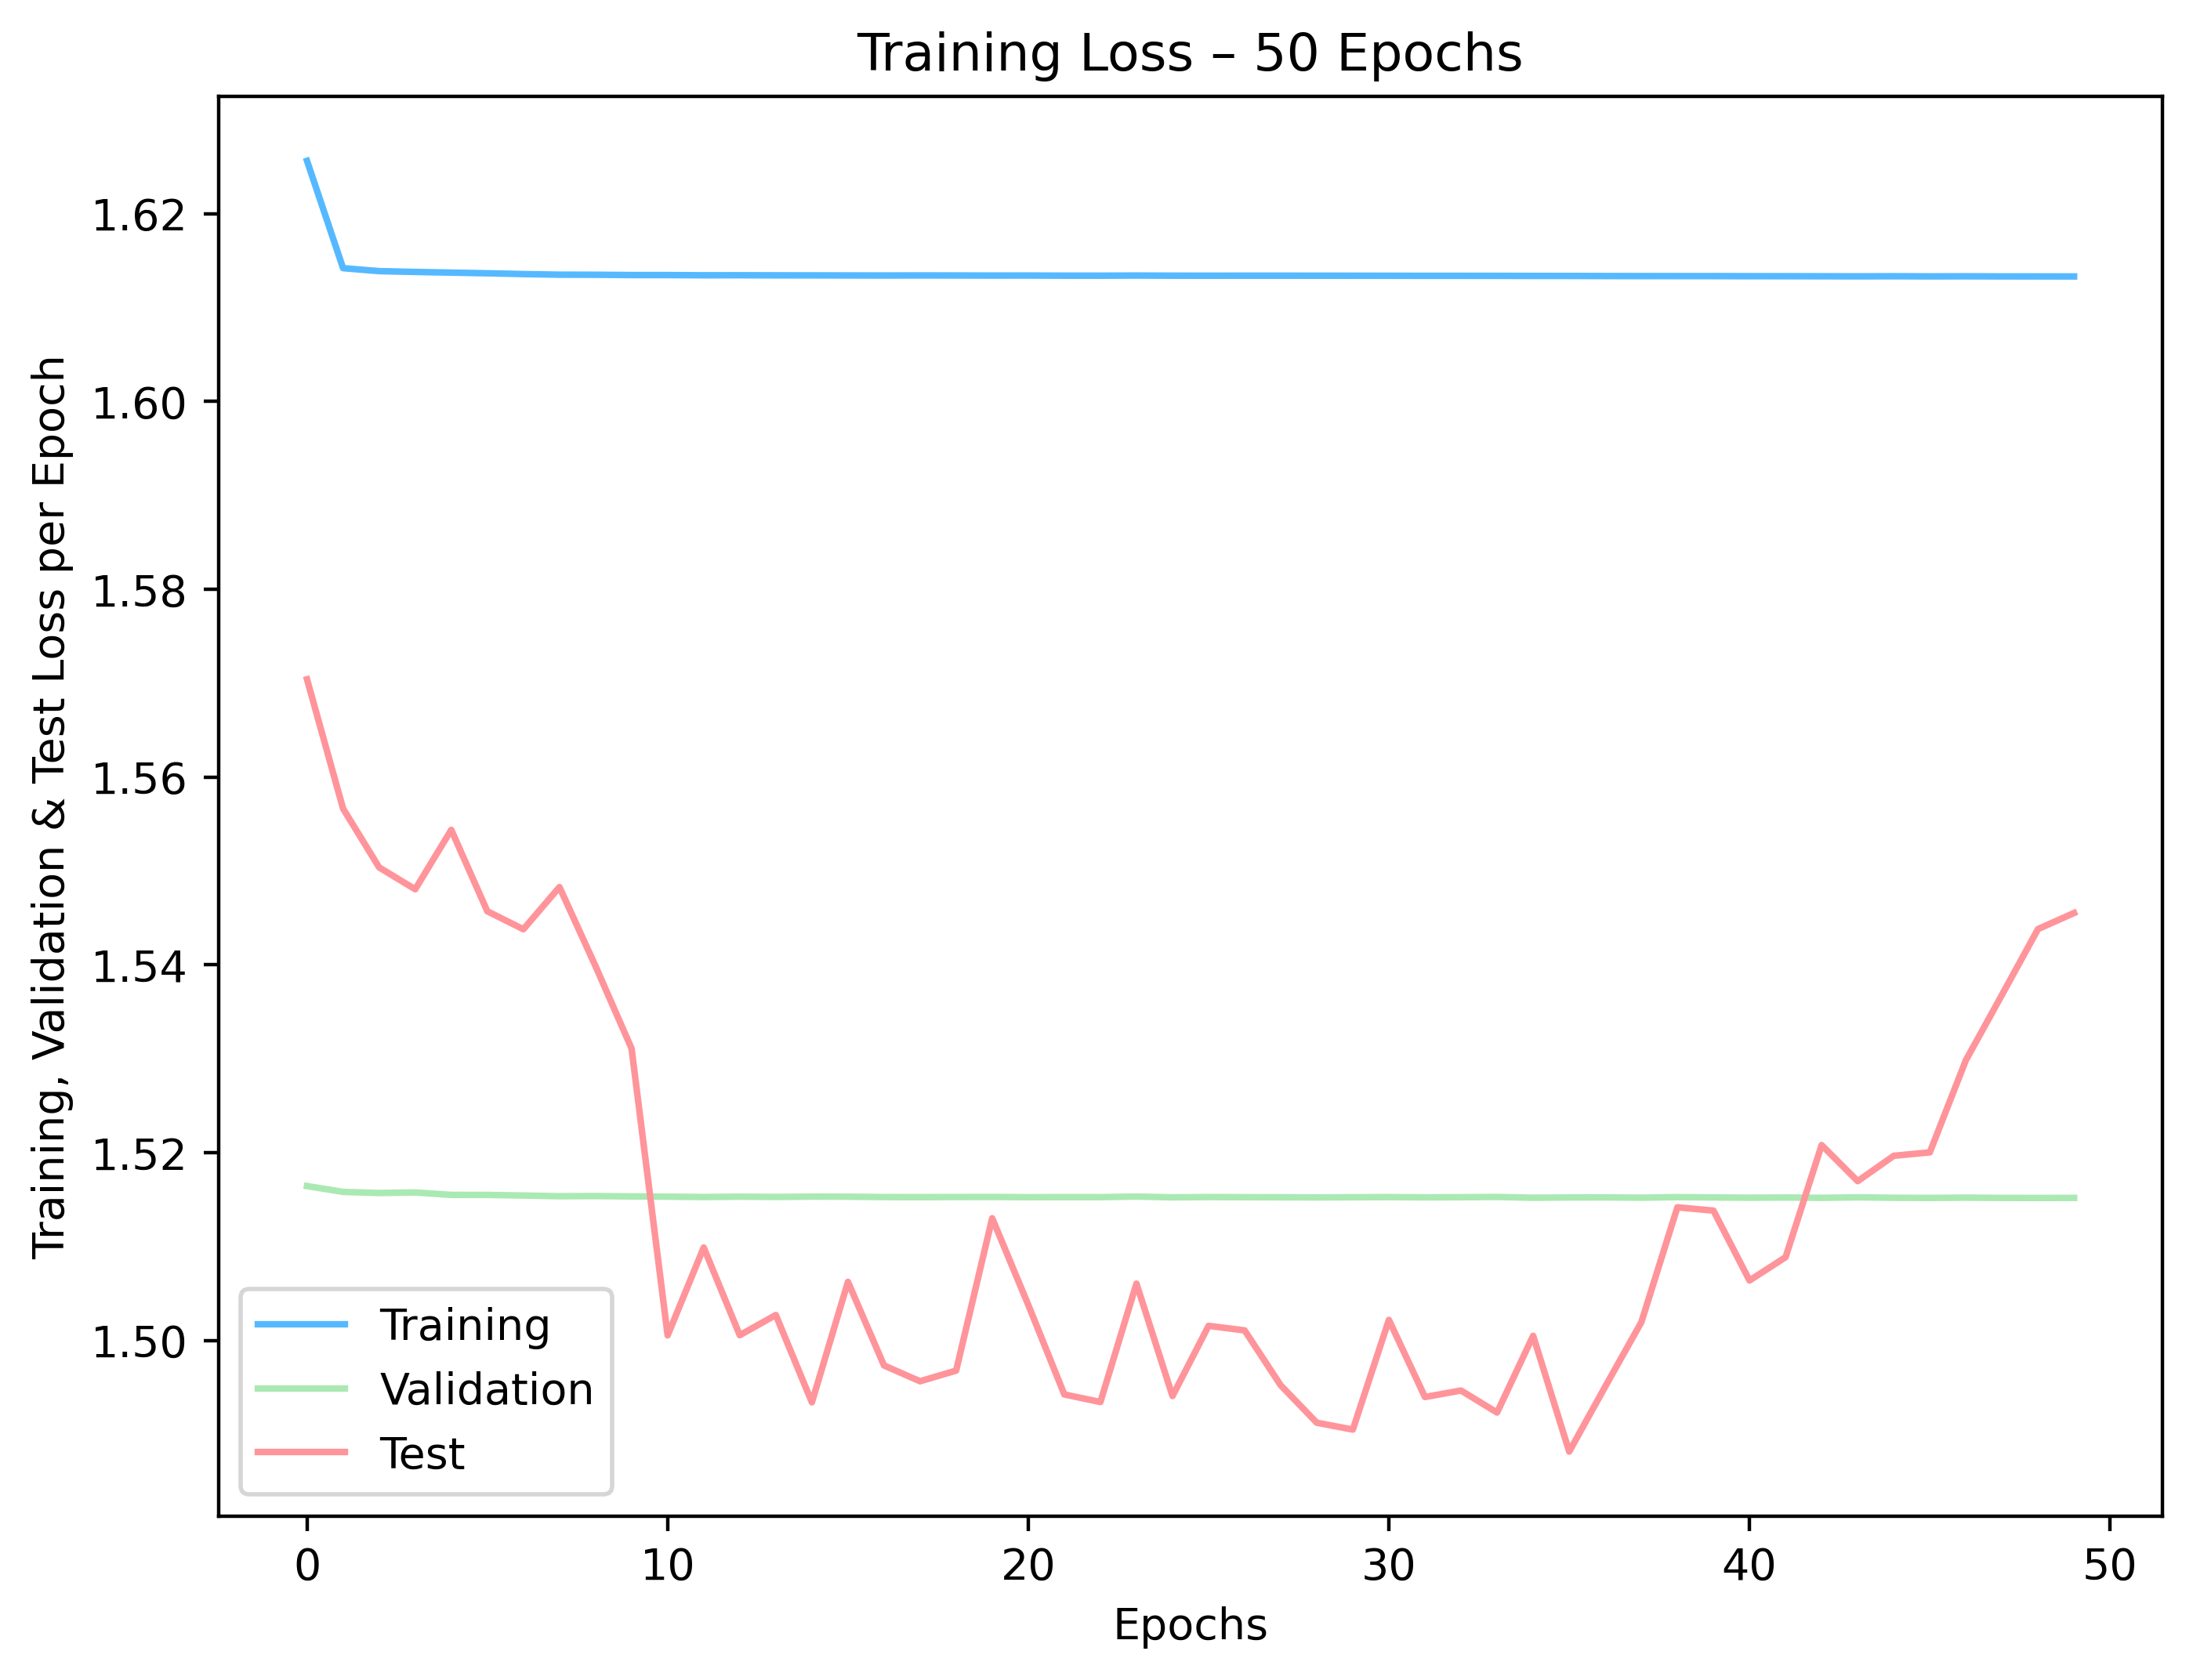

In [106]:
# Plot History from Model Training -- Accuracy 
import matplotlib.pyplot as plt 

plt.style.use('seaborn-pastel') # "seaborn-pastel" or "dark_background"
plt.figure(figsize=(8, 6), dpi=400)
plt.title(f"Training Loss – {n_epochs} Epochs")
plt.xlabel("Epochs")
plt.ylabel("Training, Validation & Test Loss per Epoch")

plt.plot(range(n_epochs), history["train"], color="#56B9FF", label="Training")
plt.plot(range(n_epochs), history["val"],   color="#ABE9B3", label="Validation")
plt.plot(range(n_epochs), history["test"],  color="#FF949A", label="Test")
plt.legend(loc="best")



- **Dense Layers have about 7.5x less parameters than same sized layers in LSTM model**

## Evaluation of Model

- Reconstruction Accuracy on Entire Set
- Plot Reconstructions against original sequences
- Linear Model seems to be having poor fit -- adding more layers might result in a better approximation?

In [107]:
reconstruction_accuracy(X_test, autoencoder) #run pass on test set, get RMSE Accuracy 

Total RMSE for Entire Set: 3064.78%
  Average RMSE per Example: 153.24%


/var/folders/25/h27pt_w92kg0719dy47wtrx80000gn/T/ipykernel_24603/1908404601.py:125: ComplexWarning: Casting complex values to real discards the imaginary part
  mse = float(mse)


Recreations of Original Signals


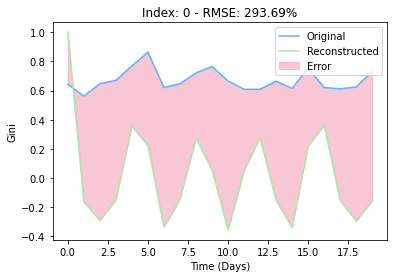

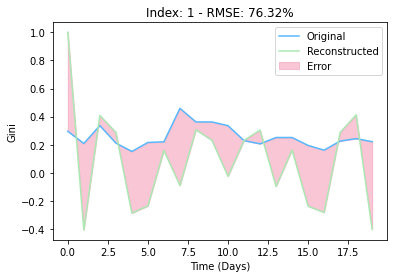

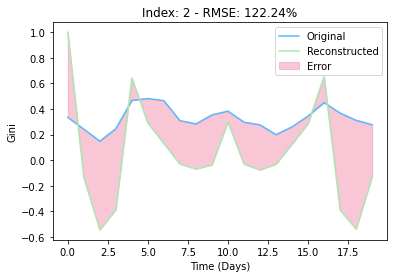

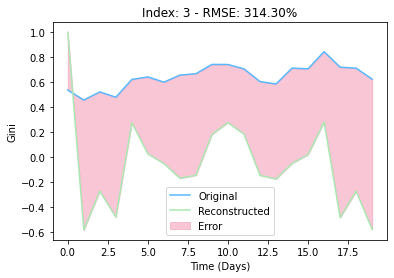

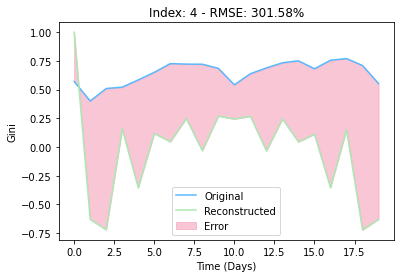

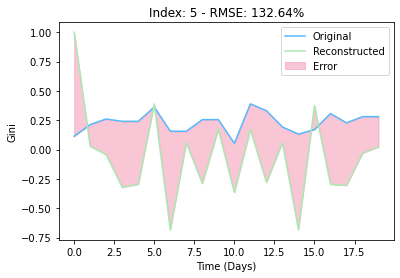

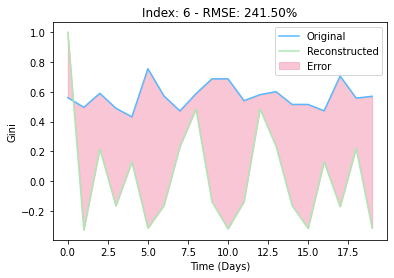

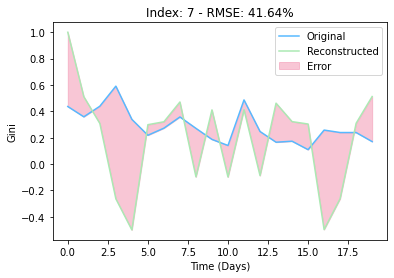

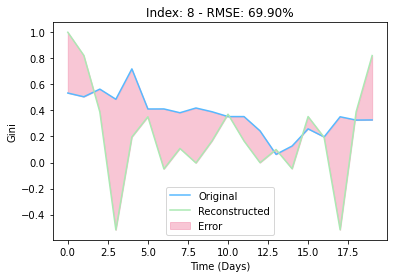

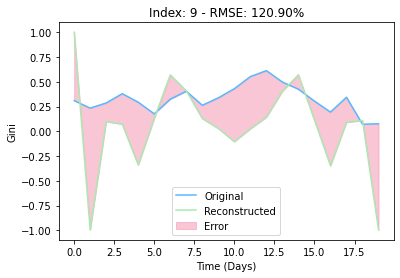

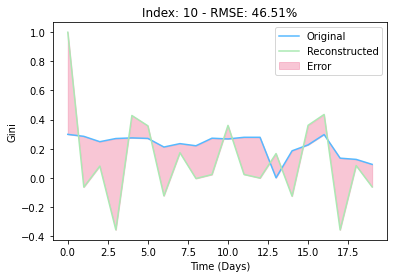

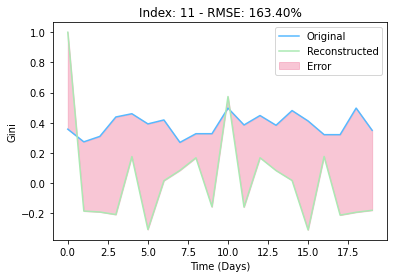

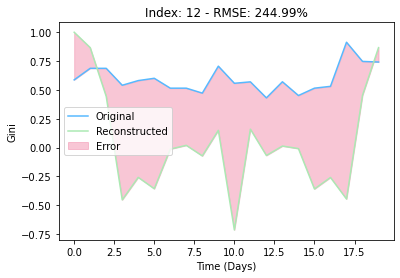

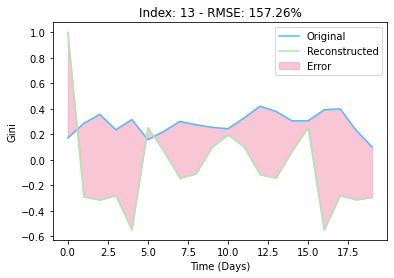

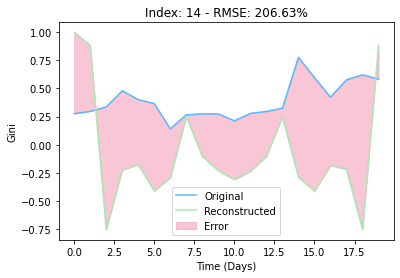

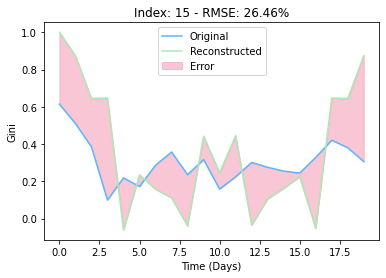

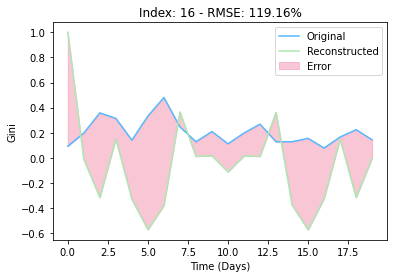

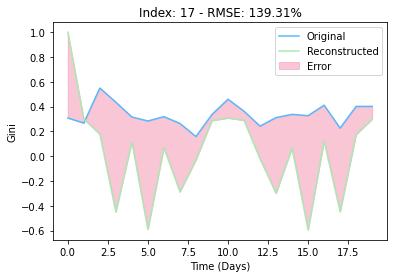

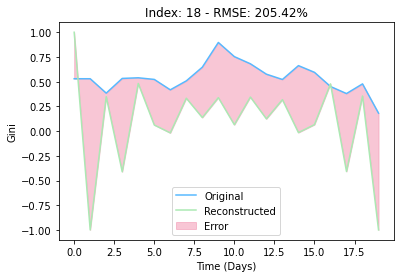

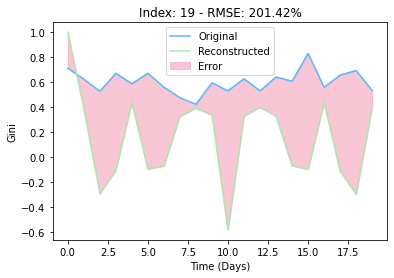

In [108]:
# View Difference Between Reconstructions and Original Sequences

# Old Method, no Inverse Fourier Transform
# plot_reconstruction(autoencoder, X_test, range(0, 20)) #plot all 
# plot_reconstruction(autoencoder, X_test, [0, 3, 7, 9, 12, 16, 19]) #plot specified subset

plot_reconstruction(autoencoder, X_test, X_test_original, range(0, 20)) #plot all 
# plot_reconstruction(autoencoder, X_test, X_test_original, [0, 3, 7, 9, 12, 16, 19]) #plot specified subset


In [64]:
fourier_transform(X_test, inverse=True)

array([[[6.43851320e-01, 5.62127747e-01, 6.46713010e-01, 6.70267892e-01,
         7.69472306e-01, 8.63666359e-01, 6.21141633e-01, 6.46784436e-01,
         7.21069639e-01, 7.65200607e-01, 6.66620561e-01, 6.08998513e-01,
         6.08998513e-01, 6.64536966e-01, 6.15352106e-01, 7.53940114e-01,
         6.21313434e-01, 6.12249460e-01, 6.25166794e-01, 7.30933168e-01]],

       [[2.95959291e-01, 2.09051649e-01, 3.36551203e-01, 2.12306826e-01,
         1.52675982e-01, 2.16579990e-01, 2.21162336e-01, 4.58840747e-01,
         3.62395192e-01, 3.62395194e-01, 3.35994047e-01, 2.29808584e-01,
         2.06547227e-01, 2.51719688e-01, 2.51719689e-01, 1.95458404e-01,
         1.61895261e-01, 2.26305960e-01, 2.43721692e-01, 2.22231827e-01]],

       [[3.34649962e-01, 2.42793767e-01, 1.48586987e-01, 2.46121001e-01,
         4.67095468e-01, 4.81858325e-01, 4.65037919e-01, 3.09519785e-01,
         2.83280234e-01, 3.54279921e-01, 3.83752212e-01, 2.96826914e-01,
         2.76430911e-01, 2.00038543e-01, 2.60